# notebook where I examine the copies of simulations 8/9/14/15

In [1]:
ph = "/n/holystore01/LABS/conroy_lab/Lab/amphillips/finished_grid/"

p8 = ph+"8_copies/"
p9 = ph+"9_copies/finished_successfully/"
p14 = ph+"14_copies/"
p15 = ph+"15_copies/"

copy_paths = [p8,p9,p14,p15]

In [2]:
script_path = "/n/home02/amphillips/p26/scripts" # for cannon
import sys
import petar
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.units as u
import astropy.coordinates as coord
from astropy.table import Table


import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

import astropy.coordinates as coord
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.dynamics import mockstream as ms
from gala.units import galactic

from tqdm import tqdm

sys.path.append(script_path)
# from analyze_petar import analyze_petar
import PETAR_ANALYSIS_FUNCTIONS as paf
import astropy.constants as const
from streamframe import StreamFrame
from scipy.stats import binned_statistic

import matplotlib.pyplot as plt
plt.style.use(script_path+'/vedant.mplstyle')
%config InlineBackend.figure_format='retina'

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import curve_fit
from scipy.stats import binom


#** only need GD1 information for these copies;
init_pos = np.array([-14680.175269960177, -18049.00342055592, -3355.258112269282]) * u.pc.to(u.kpc)
init_vel = np.array([126.94017915235732, -33.56076783776999, 112.93136486685516]) # km/s
id_gd1 = np.concatenate([init_pos, init_vel])
gd1_apocenter = 27.58821821 # from Gala integration

import io
from matplotlib.transforms import Bbox

/n/home02/amphillips/.conda/envs/petar_env/lib/python3.10/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


# information for table:

dispersion in cluster dissolution times for copied sims

In [3]:
# tdis, tplot_p, tplot_a = paf.find_dissolution_plotting_times(copy_paths[0]+"0/")

tdis_vals = []
quoted_in_paper = [10853, 5929, 7004, 2468]
for j, path in enumerate(copy_paths):
    dissolution_times_this_sim = []
    for k in range(10):
        tidal = paf.load_tidal(path+"%i/"%k)
        bound_times = tidal.time[tidal.n>=100]
        tdis = int(max(bound_times))
        dissolution_times_this_sim.append(tdis)
    tdis_this_sim = np.array(dissolution_times_this_sim)

    # fig, ax = plt.subplots()
    # ax.hist(dissolution_times_this_sim, bins=5)
    # ax.axvline(quoted_in_paper[j], c='r')
    med = np.median(tdis_this_sim)
    disp = np.percentile(tdis_this_sim, 84) - np.percentile(tdis_this_sim, 16)
    print(r"%i +\- %i"%(round(med,-1), round(disp,-1)), "|", quoted_in_paper[j])
    tdis_vals.append(dissolution_times_this_sim)

11100 +\- 2400 | 10853
9540 +\- 3320 | 5929
7060 +\- 830 | 7004
2850 +\- 770 | 2468


# stacking MF evolution figure

In [4]:
time_cmap = paf.define_time_cmap()

### mass function

In [5]:
# mass function business!! 

# load data + make histograms first: 

hists_all_sims = []


t_tdis_list = np.linspace(0,1,11)
bins = np.linspace(np.log10(0.08), np.log10(10), 30)
bin_centers = (bins[:-1]+bins[1:])/2

for j, path_head in enumerate(copy_paths): ### OUTER LOOP: DIFFERENT SIMS
    tdis_vals_this_sim = tdis_vals[j]
    hists_this_sim = []
    print("working on sim %i/%i"%(j+1, len(copy_paths)))
    for k, tdis_frac in enumerate(t_tdis_list): #### NEXT LAYER: LOOP THROUGH TIMES
        print("working on t/tdis="+str(tdis_frac))
        logM_this_time = []
        for kk in range(len(tdis_vals_this_sim)): #### LAST LAYER: FOR EACH TIME, LOOP FOR SIMULATIONS AT THIS STAGE AND EXTRACT MASSES
            path = path_head+"%i/"%kk
            tdis = tdis_vals_this_sim[kk]
            t_hist = np.round(tdis_frac * tdis, -1).astype(int)

            particles = paf.load_particle(path, t_hist, file_naming_convention="every 10")
            rrel, clip = paf.clip_outside_rtid(path, particles, t_hist,
                                               in_core_frame=False,
                                               file_naming_convention="every 10")
            masses = particles.mass[clip]
            logM = np.log10(masses)
            logM_this_time.append(logM) # COLLECT STACKED MASSES AT THIS TIME

        all_logM = np.concatenate(logM_this_time) 
        N = len(all_logM)
        y, edges = np.histogram(all_logM, bins=bins)#, density=True) # weights = np.zeros_like(all_logM)+1/all_logM.size) # FOR EACH TIME, MAKE A HISTOGRAM OF STACKED MASSES
        bin_widths = np.diff(bins)
        y = N**(-1) * y / bin_widths    # 1/N * dN/dlogM
        hists_this_sim.append(y)# y) # Add the stacked histogram to a list for this simulation

    hists_all_sims.append(hists_this_sim) # add the hists at all times to an outermost list. 


working on sim 1/4
working on t/tdis=0.0
working on t/tdis=0.1
working on t/tdis=0.2
working on t/tdis=0.30000000000000004
working on t/tdis=0.4
working on t/tdis=0.5
working on t/tdis=0.6000000000000001
working on t/tdis=0.7000000000000001
working on t/tdis=0.8
working on t/tdis=0.9
working on t/tdis=1.0
working on sim 2/4
working on t/tdis=0.0
working on t/tdis=0.1
working on t/tdis=0.2
working on t/tdis=0.30000000000000004
working on t/tdis=0.4
working on t/tdis=0.5
working on t/tdis=0.6000000000000001
working on t/tdis=0.7000000000000001
working on t/tdis=0.8
working on t/tdis=0.9
working on t/tdis=1.0
working on sim 3/4
working on t/tdis=0.0
working on t/tdis=0.1
working on t/tdis=0.2
working on t/tdis=0.30000000000000004
working on t/tdis=0.4
working on t/tdis=0.5
working on t/tdis=0.6000000000000001
working on t/tdis=0.7000000000000001
working on t/tdis=0.8
working on t/tdis=0.9
working on t/tdis=1.0
working on sim 4/4
working on t/tdis=0.0
working on t/tdis=0.1
working on t/tdi

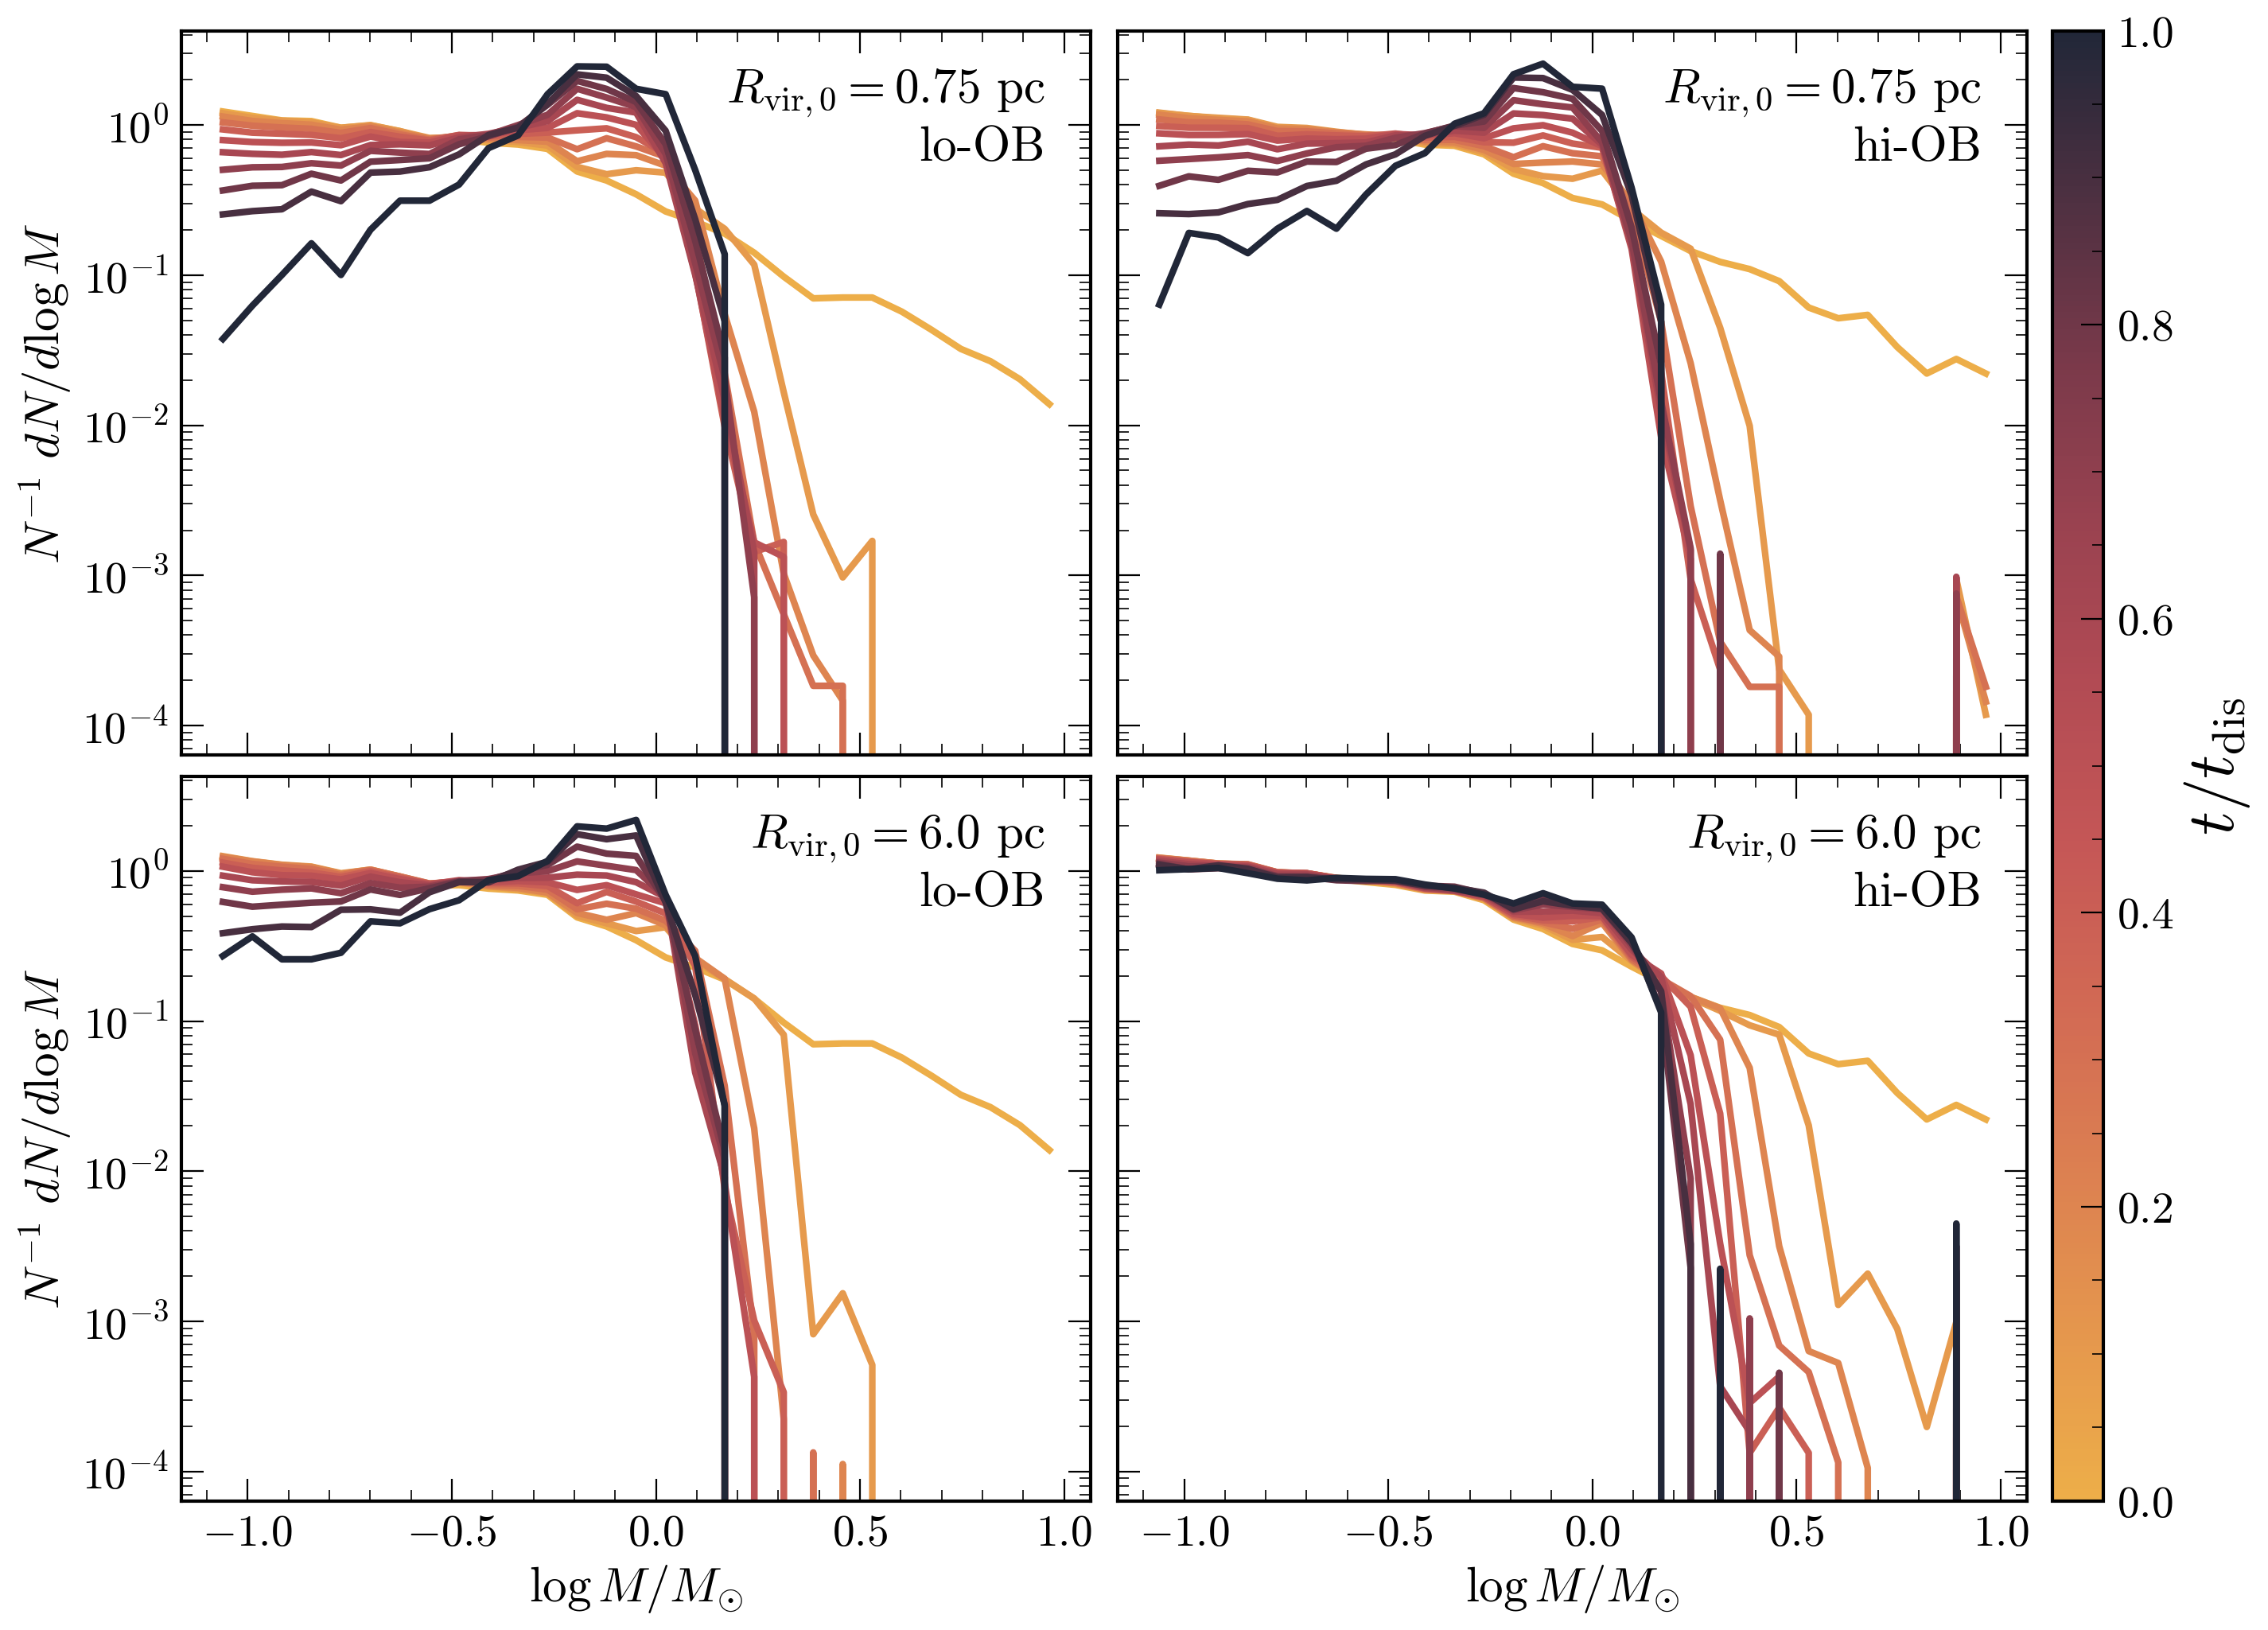

In [6]:
colors = time_cmap(np.linspace(0,1,len(t_tdis_list)))
c_index = 0

fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(16,12), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.03, hspace=0.03)

ax_list = [ax1,ax2,ax3,ax4]


for ax in [ax1,ax3]:
    ax.set_ylabel(r"$N^{-1}\ dN/d\log M$")

for ax in [ax3,ax4]:
    ax.set_xlabel(r"$\log M/M_{\odot}$")

# plot_labels = ["$R_{\\rm{vir},0}=0.75$ pc\n$N_{\\rm OB}=86$", 
#                 "$R_{\\rm{vir},0}=0.75$ pc\n$N_{\\rm OB}=137$",
#                 "$R_{\\rm{vir},0}=6.0$ pc\n$N_{\\rm OB}=86$",
#                 "$R_{\\rm{vir},0}=6.0$ pc\n$N_{\\rm OB}=137$"]

plot_labels = ["$R_{\\rm{vir},0}=0.75$ pc\nlo-OB", 
                "$R_{\\rm{vir},0}=0.75$ pc\nhi-OB",
                "$R_{\\rm{vir},0}=6.0$ pc\nlo-OB",
                "$R_{\\rm{vir},0}=6.0$ pc\nhi-OB"]

for k in range(len(ax_list)):
    c_index=0
    ax = ax_list[k]
    hists_all_times = hists_all_sims[k]
    for hist in hists_all_times:
        ax.plot(bin_centers, hist, c=colors[c_index])
        c_index+=1
    ax.set_yscale('log')
    ax.text(0.95, 0.95, plot_labels[k], transform=ax.transAxes, ha='right', va='top')

norm = Normalize(vmin=0, vmax=max(t_tdis_list))
sm = ScalarMappable(norm=norm, cmap=time_cmap)
sm.set_array([])

fig.subplots_adjust(right=0.85)
fig.canvas.draw()
axes = [a for a in fig.axes if a.get_visible()]
boxes = [a.get_position() for a in axes]
bottom = min(b.y0 for b in boxes)
top = max(b.y1 for b in boxes)
right = max(b.x1 for b in boxes)

pad, cb_width=0.01, 0.02
cax = fig.add_axes([right+pad, bottom, cb_width, top-bottom])

cb = fig.colorbar(sm, cax=cax)
cb.set_label(r"$t/t_{\rm{dis}}$", fontsize=30)

plt.savefig("plots/bound_MF_stacked.pdf", dpi=300, bbox_inches="tight")

# remnant fraction in cluster...

In [36]:
np.array([1])/np.array([0])

/tmp/ipykernel_2743401/1478048614.py:1: RuntimeWarning: divide by zero encountered in divide
  np.array([1])/np.array([0])


array([inf])

8


  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:01<00:00,  6.81it/s]


9


100%|██████████| 11/11 [00:01<00:00,  6.83it/s]


14


100%|██████████| 11/11 [00:01<00:00,  6.93it/s]


15


100%|██████████| 11/11 [00:01<00:00,  6.93it/s]


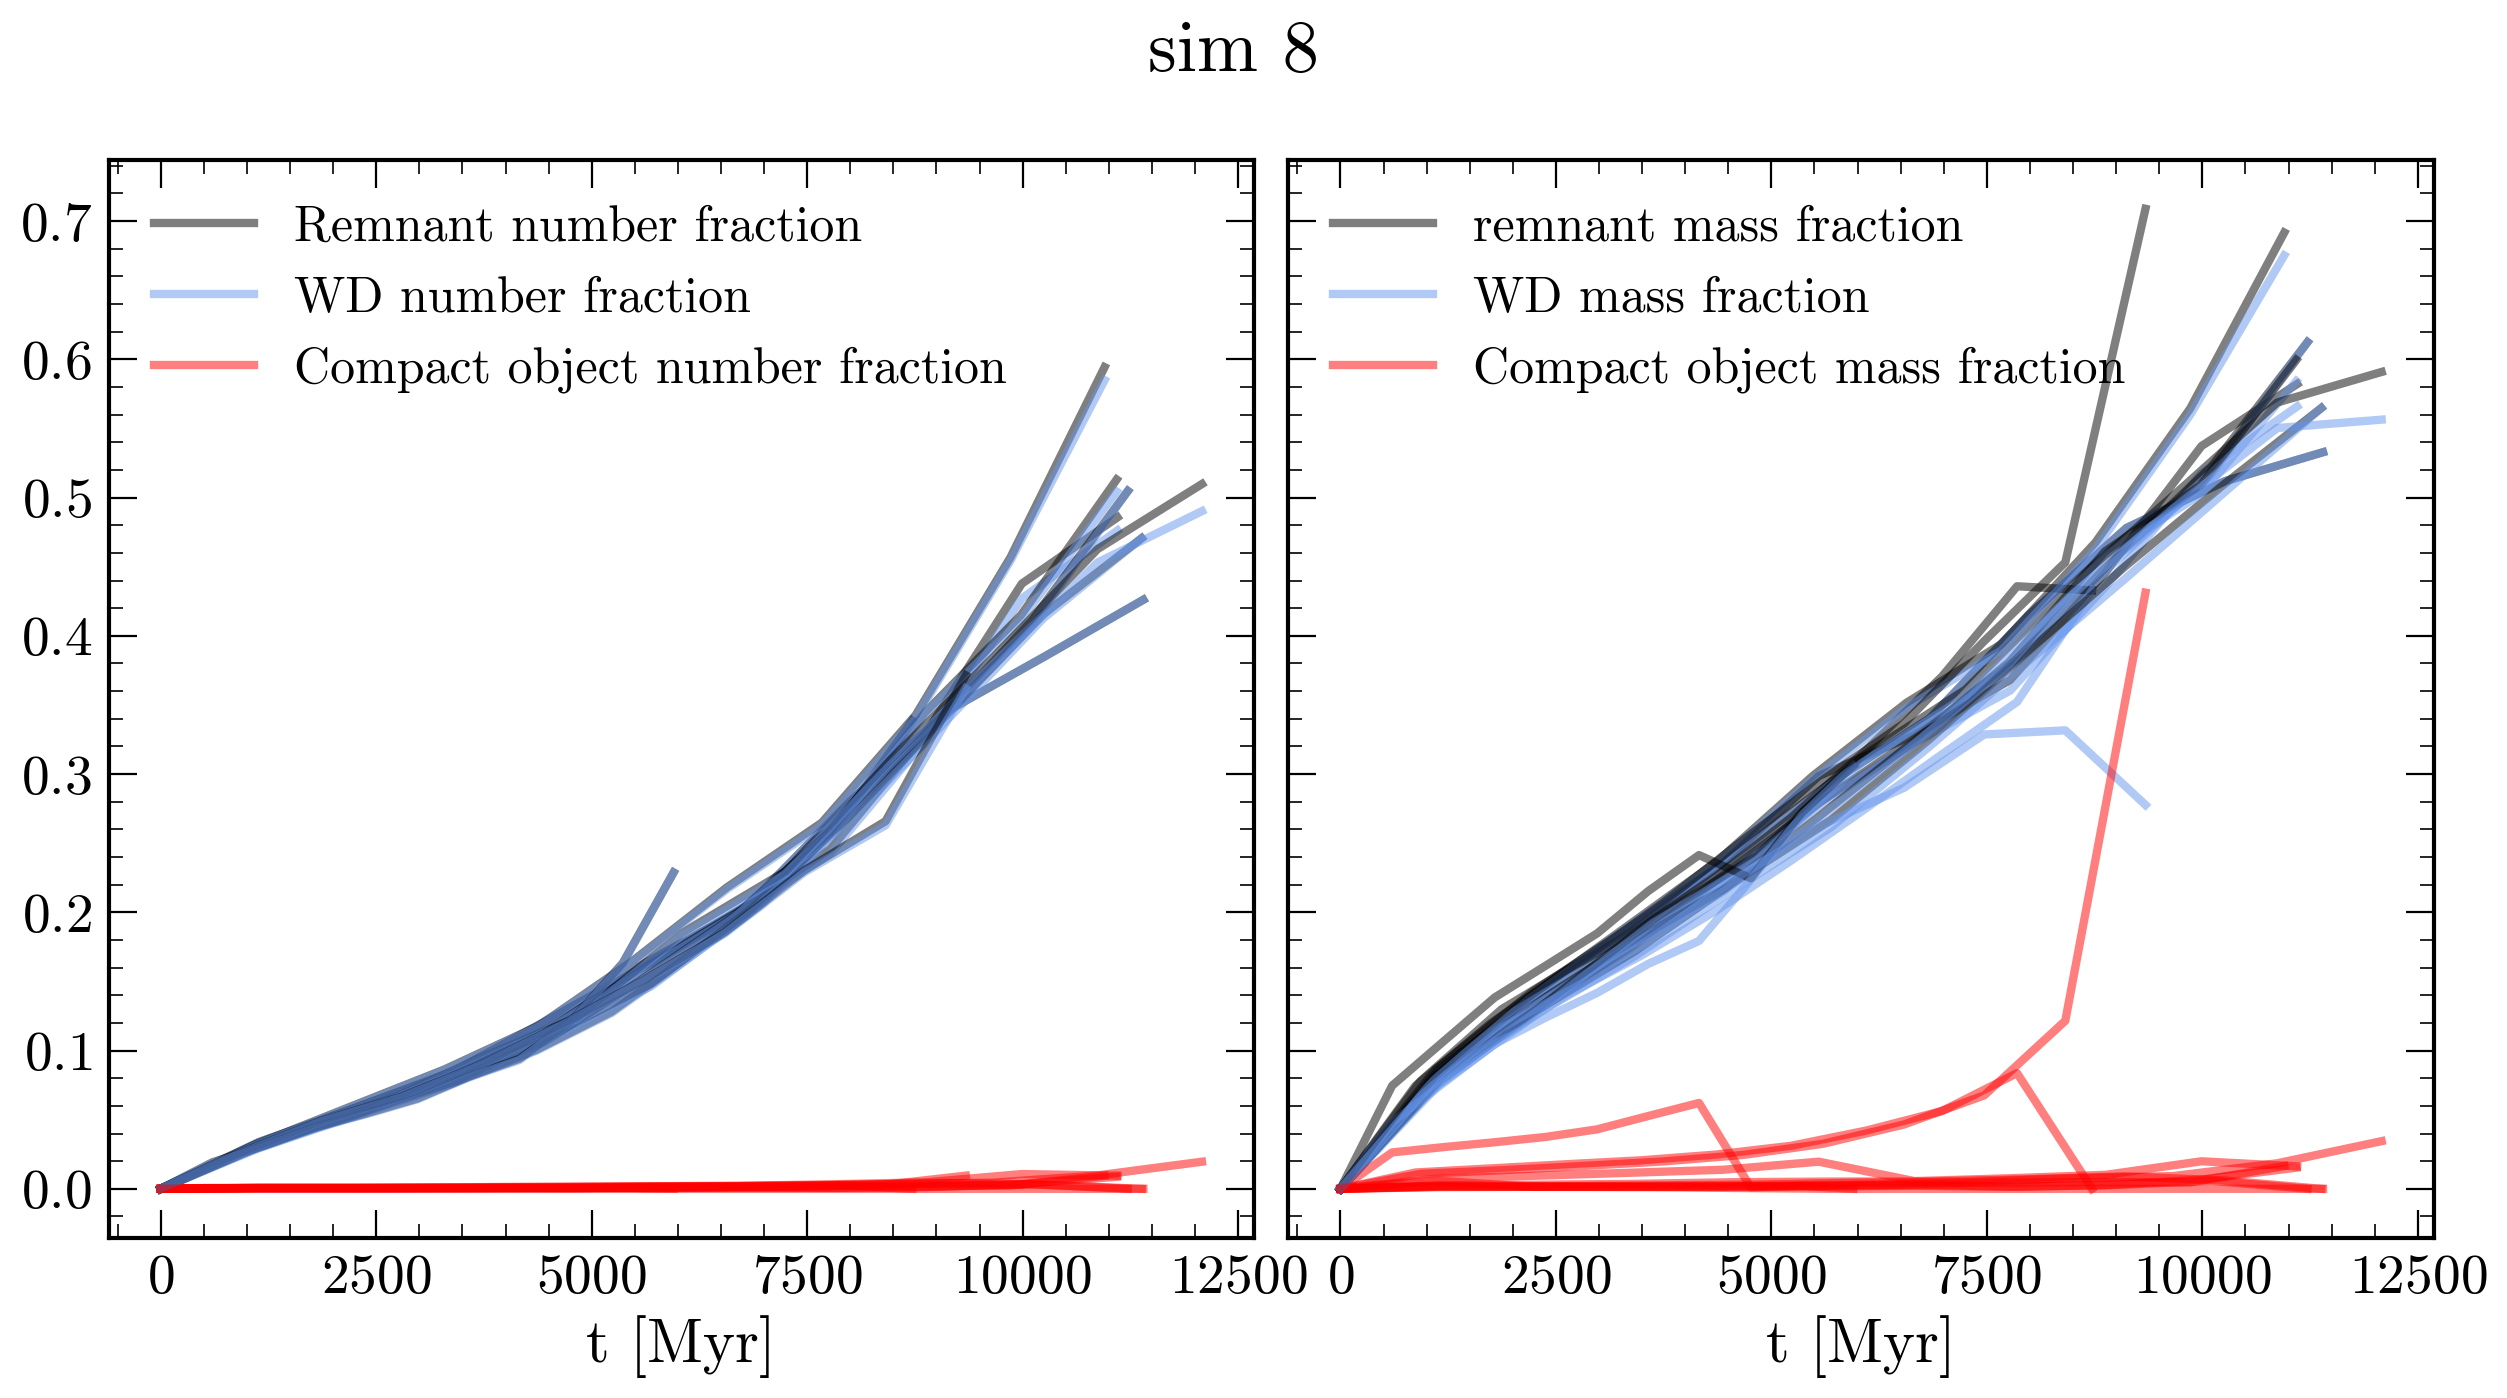

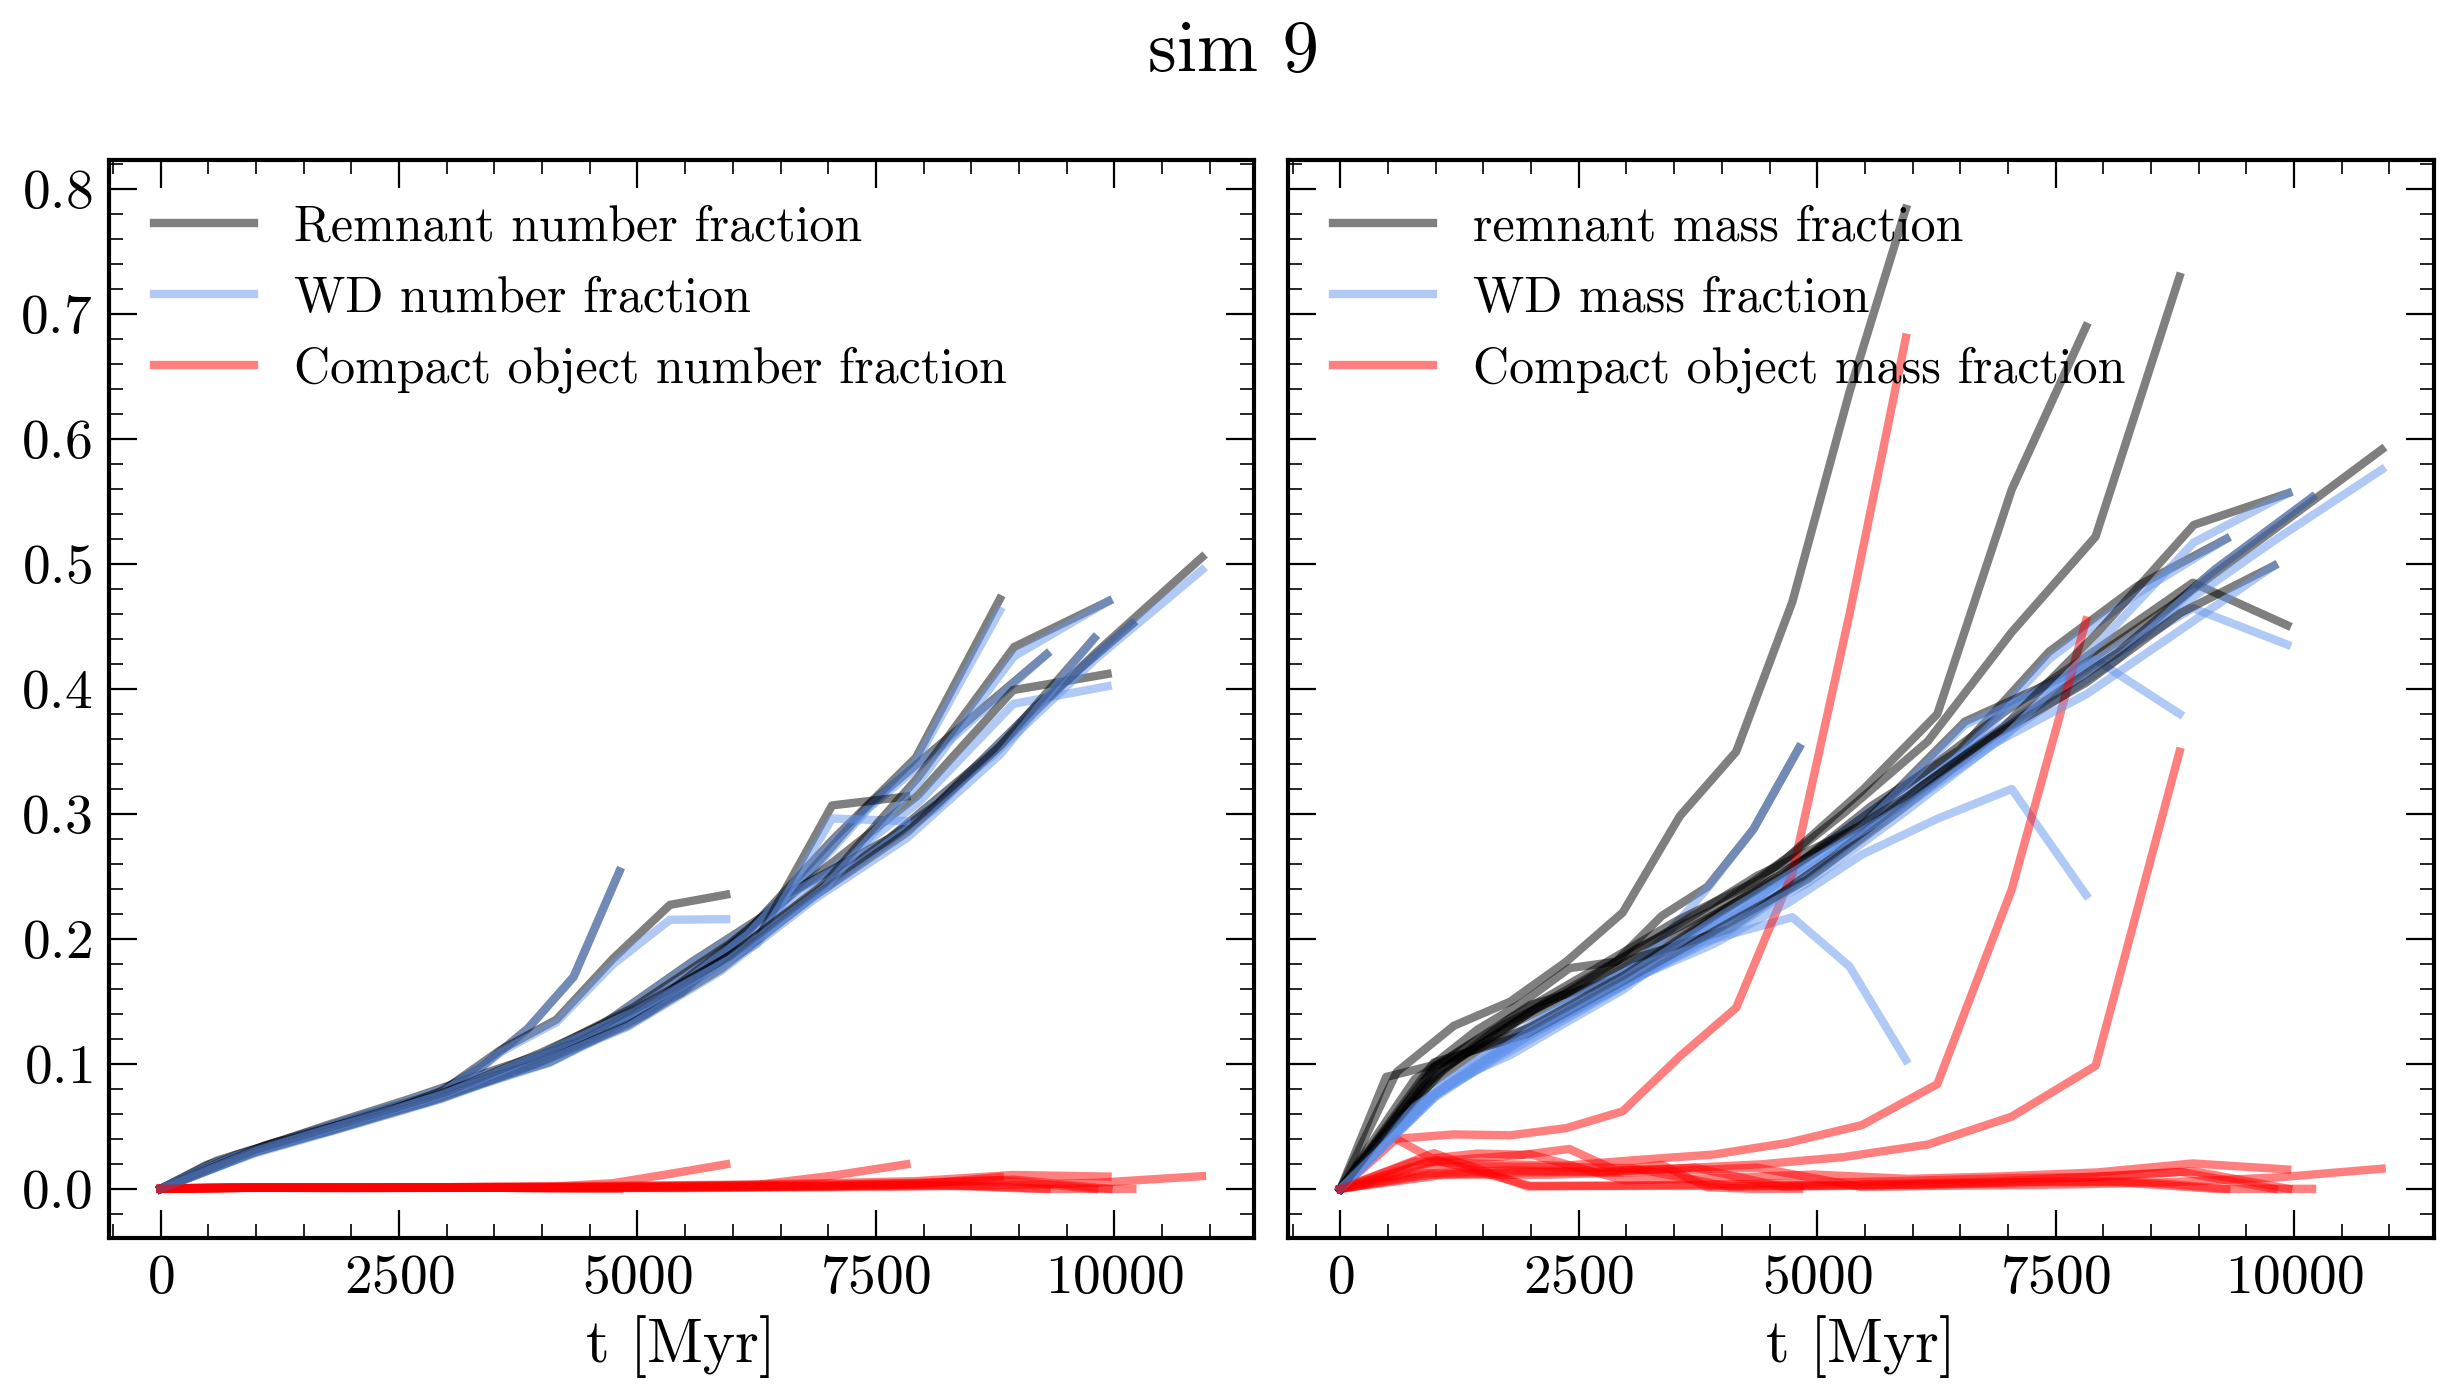

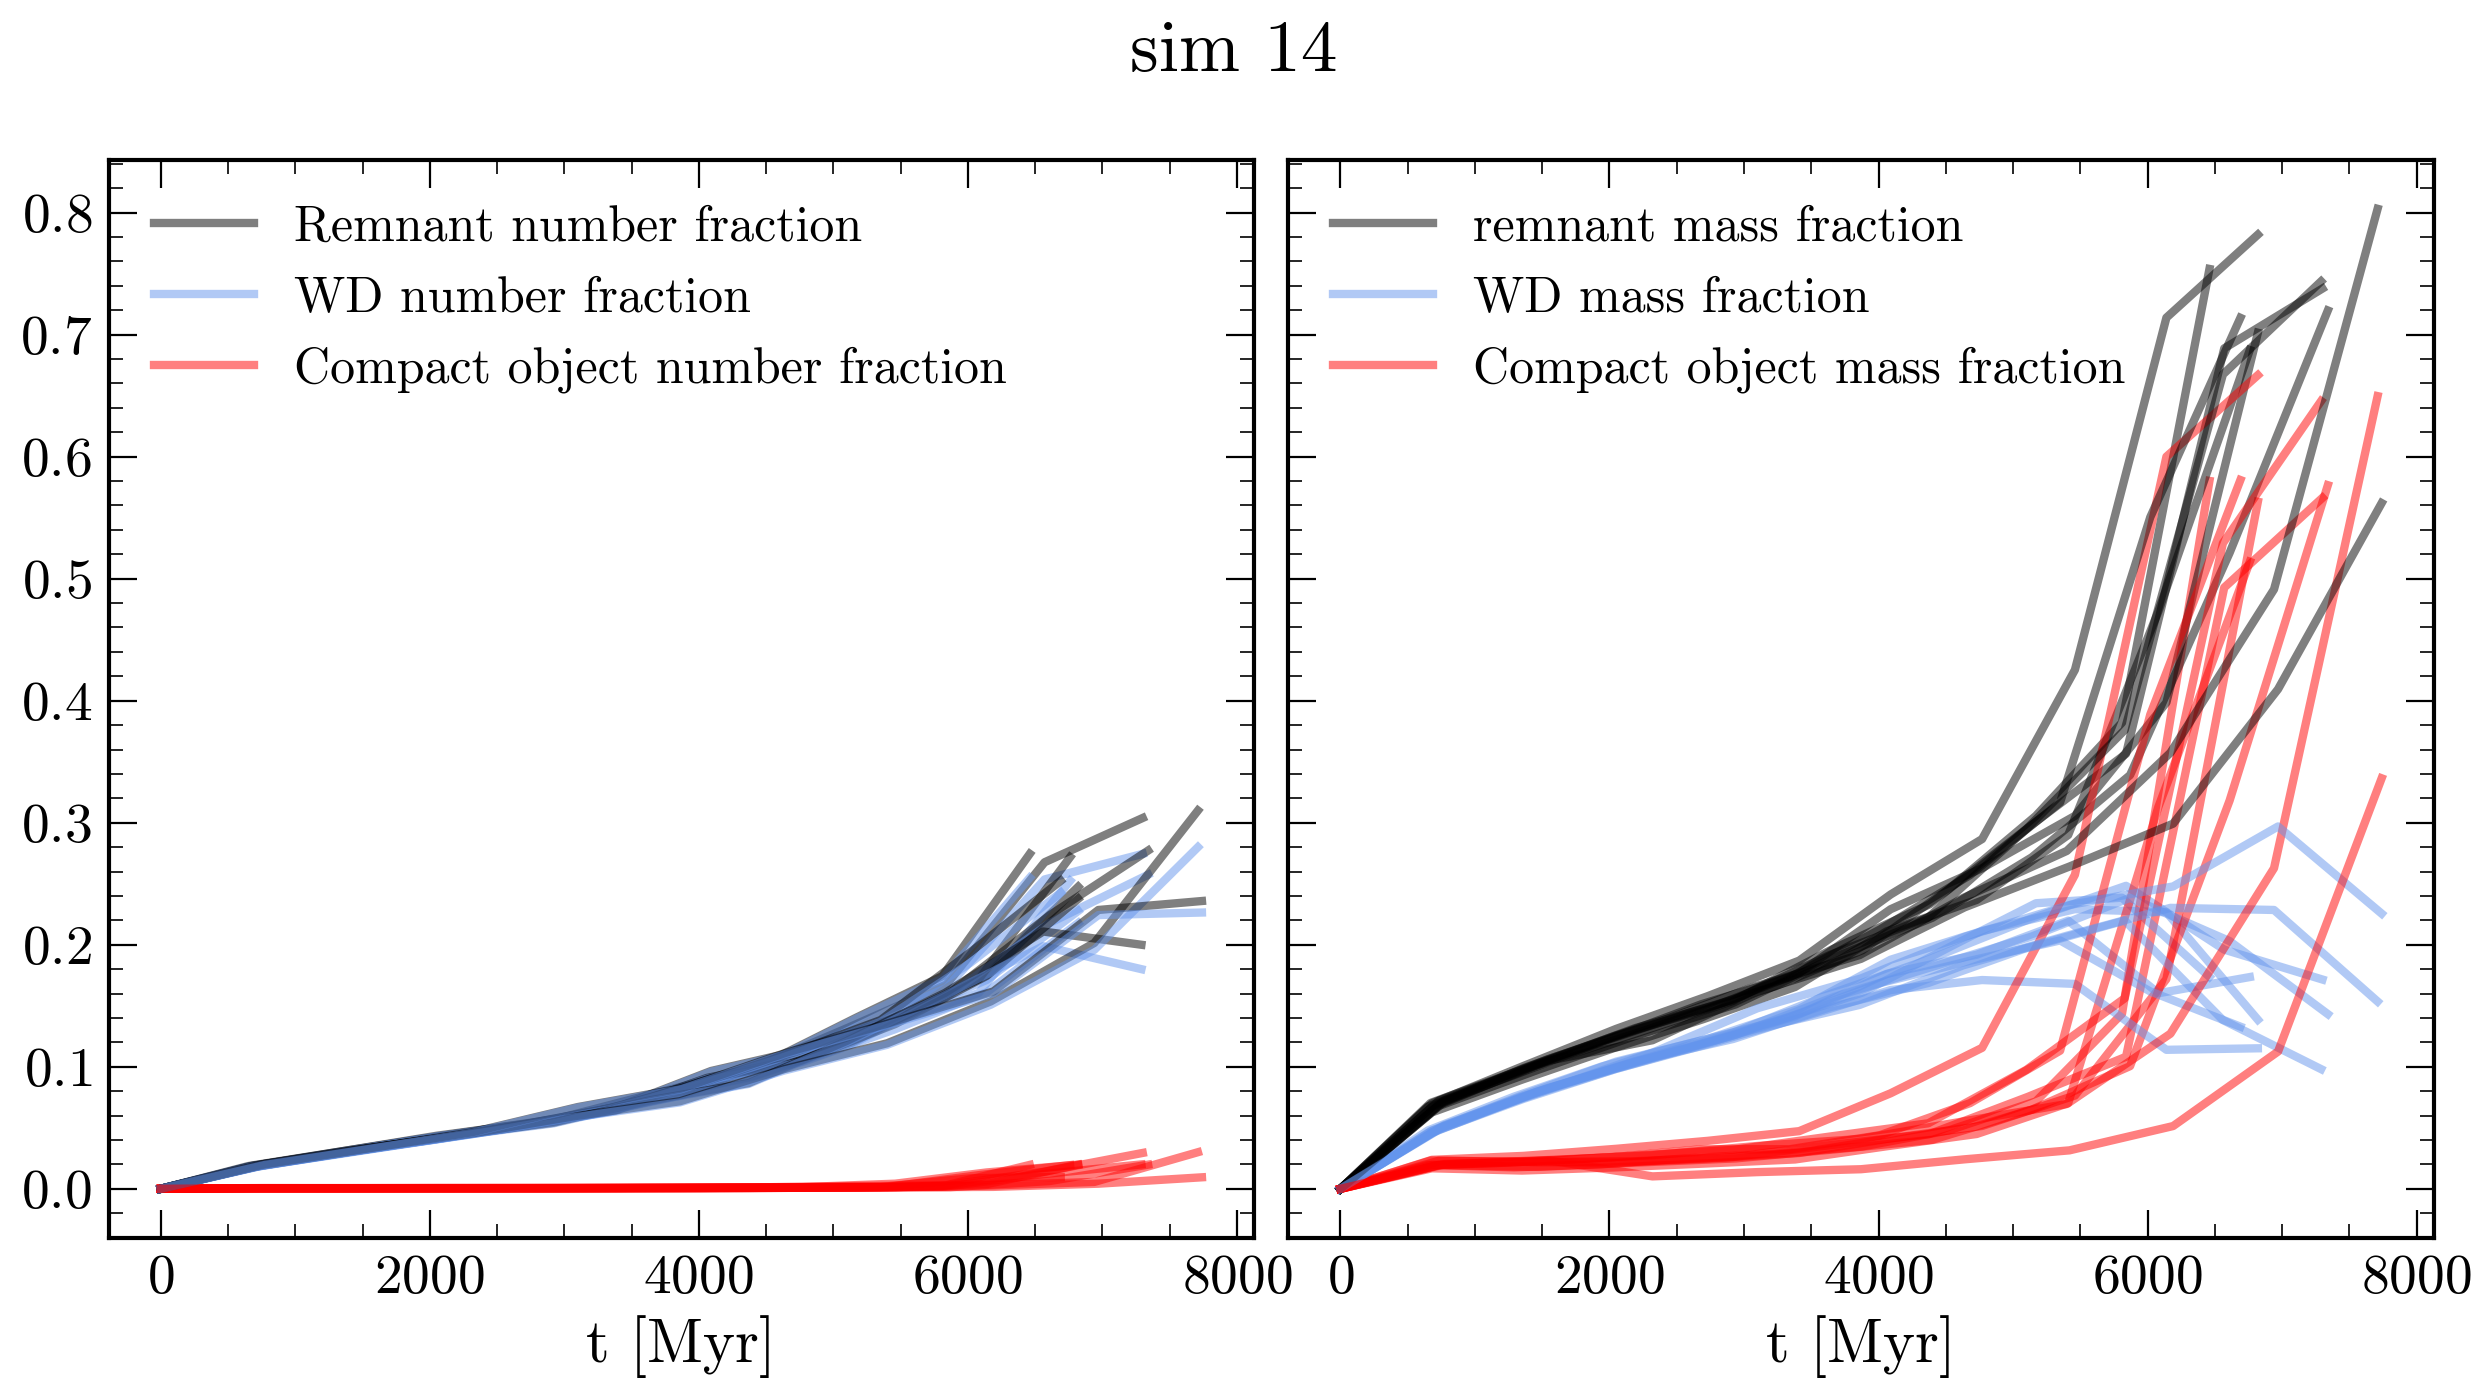

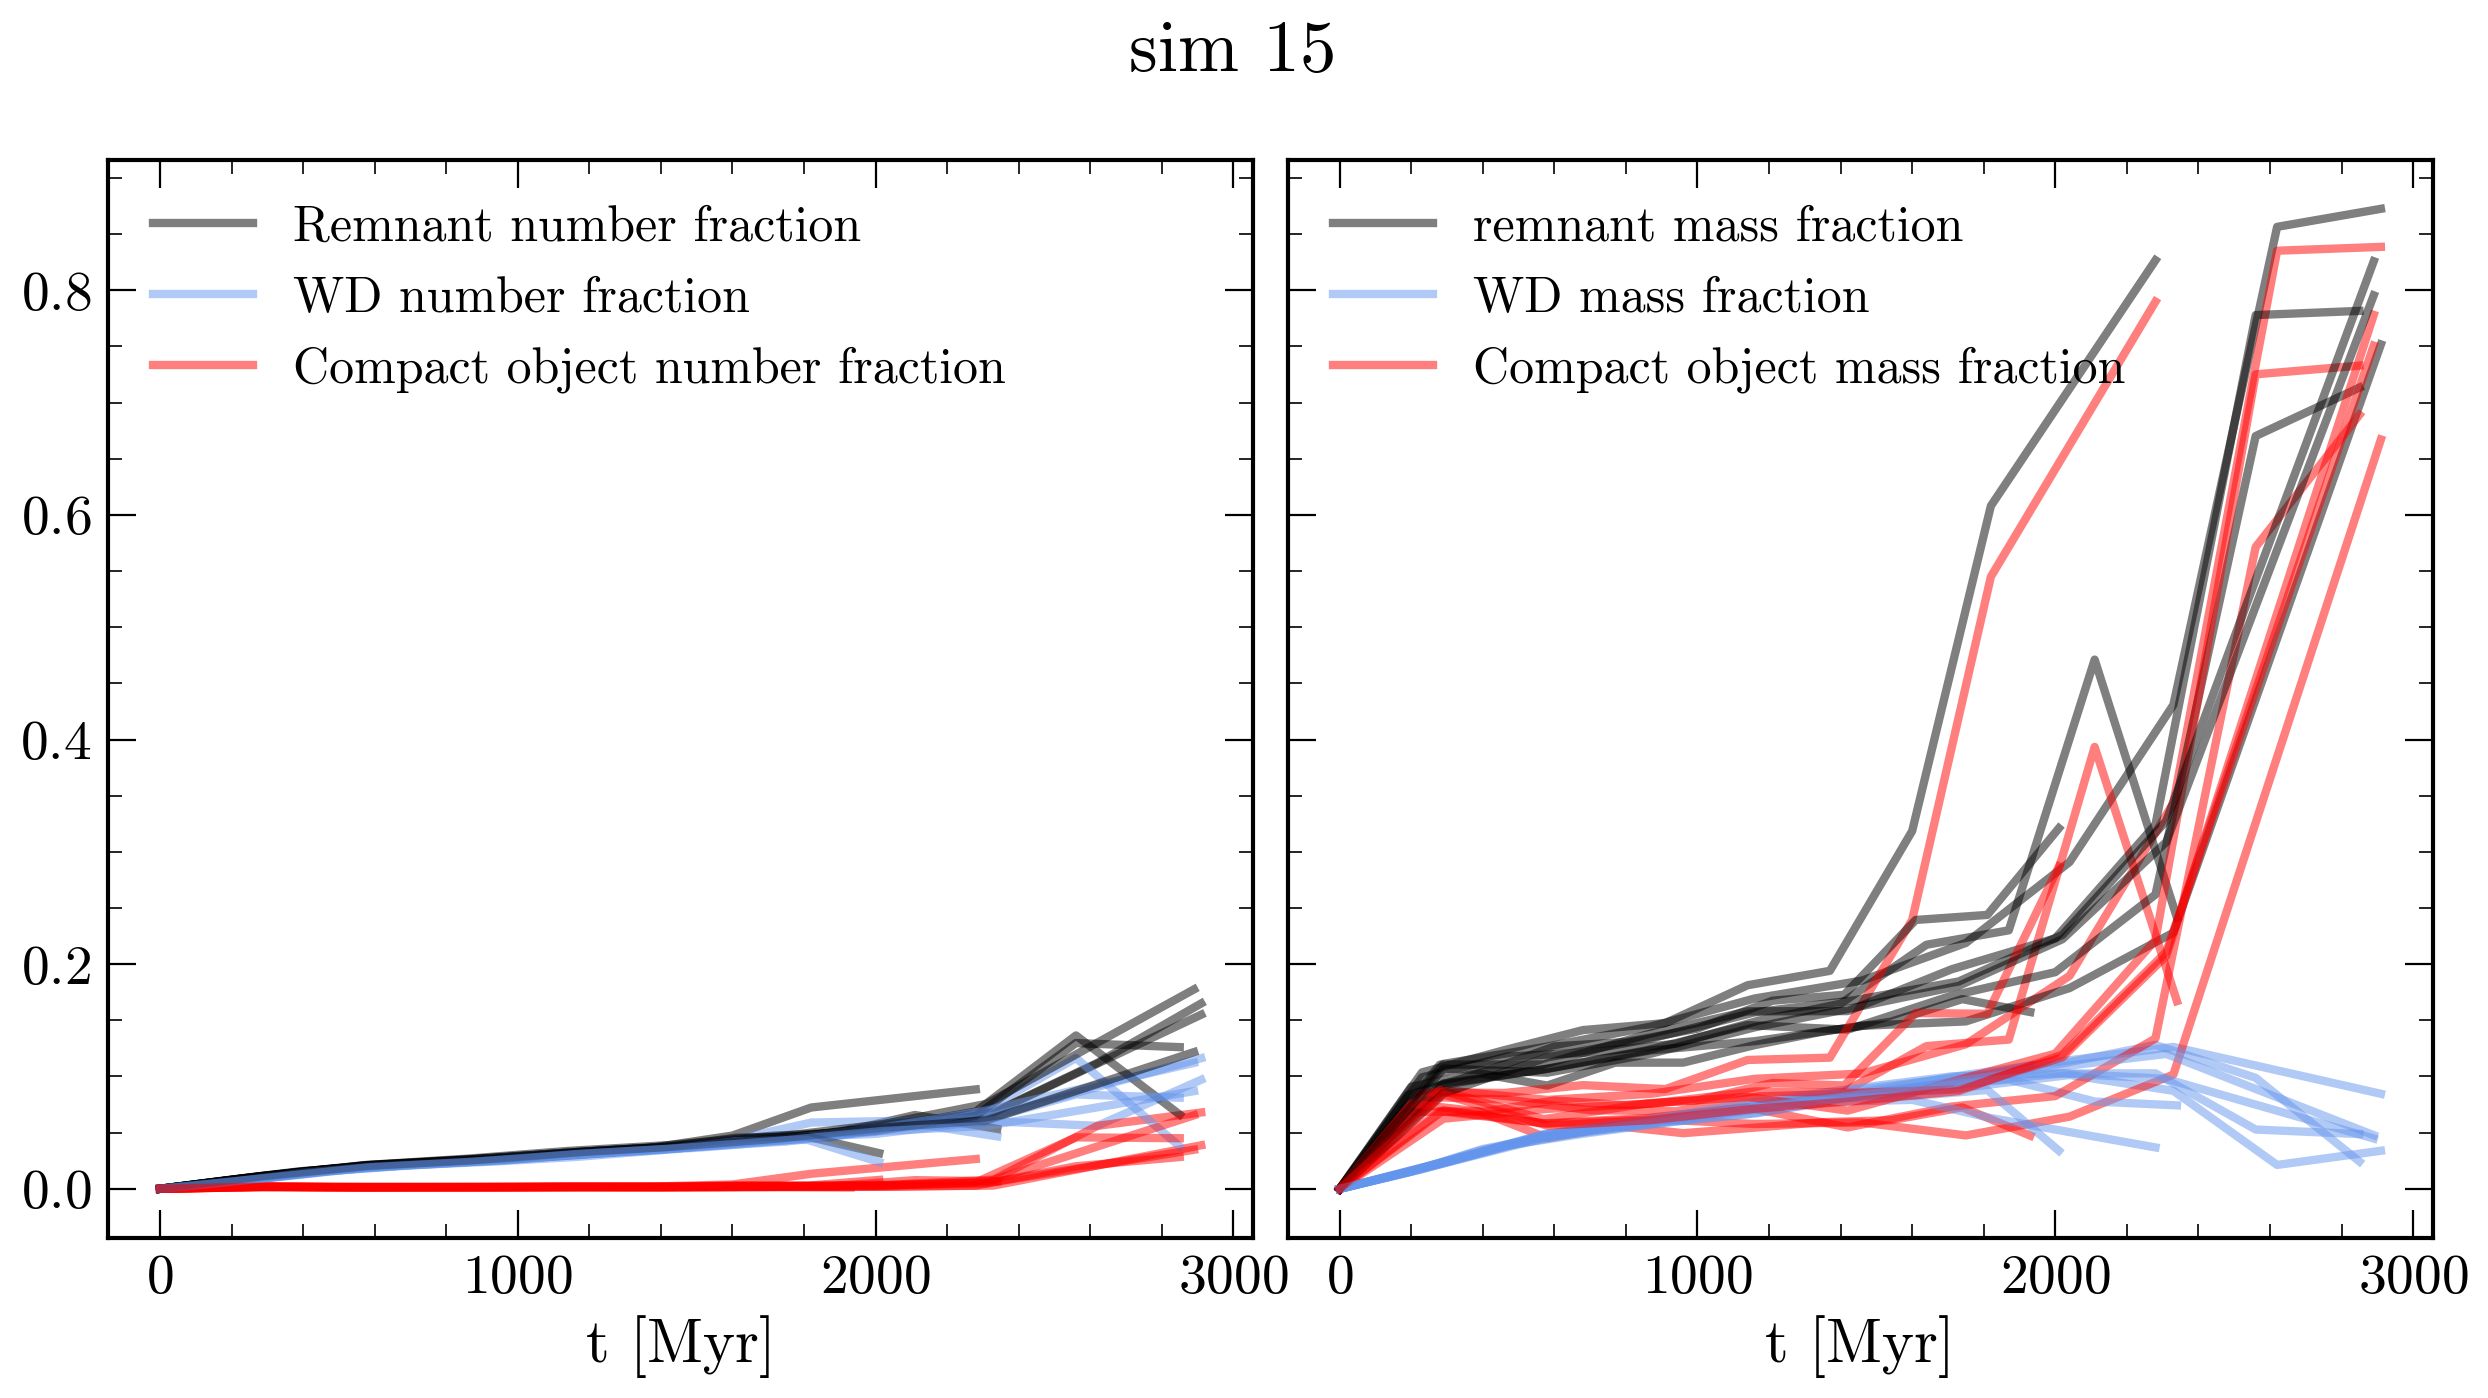

In [55]:
paths = ['','','','','','','','',p8,p9,'','','','',p14,p15,'','','','','','','','','']

sim_n=8


for sim_n in [8,9,14,15]:
    print(sim_n)
    fig, axs = plt.subplots(1,2,figsize=[15,7], sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.03, hspace=0.03)
    fig.suptitle("sim %i"%sim_n)

    for copy_n in range(10):
        # print("copy %i"% copy_n)
        path = paths[sim_n]+"%i/"%copy_n


        map_to_tdis = [0,0,0,0,0,0,0,0,
                        0,1,0,0,0,0,2,3,
                        0,0,0,0,0,0,]

        tdis = tdis_vals[map_to_tdis[sim_n]][copy_n]
        # print(tdis)
        t_tdis_list = np.linspace(0, 1, 11)
        # print(t_tdis_list)
        f_rems = []
        f_wds = []
        f_cos = []

        remnant_mass_fractions = []
        wd_mass_fractions = []
        co_mass_fractions = []


        i_list = []
        for tdis_frac in tqdm(t_tdis_list):
            t_hist = np.round(tdis_frac * tdis, -1).astype(int)
            # print(t_hist)
            

            particles = paf.load_particle(path, t_hist, file_naming_convention="every 10")
            rrel, clip = paf.clip_outside_rtid(path, particles, t_hist, in_core_frame=False, file_naming_convention="every 10")

            stellar_types = particles.star.type

            select_remnants = stellar_types>=10
            select_wd = (stellar_types==10) | (stellar_types==11) | (stellar_types==12)
            select_compact_obj = stellar_types>=13

            if len(particles.mass[clip])>0:
                n_rem = len(particles.mass[select_remnants & clip])
                f_rem = n_rem / len(particles.mass[clip])

                n_co = len(particles.mass[select_compact_obj & clip])
                n_wd = len(particles.mass[select_wd & clip])

                f_co = n_co/len(particles.mass[clip])
                f_wd = n_wd/len(particles.mass[clip])

                mass_co = np.sum(particles.mass[select_compact_obj & clip])
                mass_wd = np.sum(particles.mass[select_wd & clip])

                mass_rems = np.sum(particles.mass[select_remnants & clip])
                mass_total = np.sum(particles.mass[clip])
                
                rem_mass_frac = mass_rems/mass_total

                co_mass_frac = mass_co/mass_total
                wd_mass_frac = mass_wd/mass_total


                f_rems.append(f_rem)
                remnant_mass_fractions.append(rem_mass_frac)

                f_cos.append(f_co)
                co_mass_fractions.append(co_mass_frac)

                f_wds.append(f_wd)
                wd_mass_fractions.append(wd_mass_frac)

                i_list.append(t_hist)

        axs[0].plot(i_list, np.array(f_rems), c='k',alpha=0.5, label="Remnant number fraction" if copy_n==0 else None)
        axs[0].plot(i_list, f_wds, c='cornflowerblue',alpha=0.5, label="WD number fraction" if copy_n==0 else None)
        axs[0].plot(i_list, f_cos, c='r',alpha=0.5, label="Compact object number fraction" if copy_n==0 else None)

        axs[1].plot(i_list, np.array(remnant_mass_fractions), c='k',alpha=0.5, label="remnant mass fraction" if copy_n==0 else None)
        axs[1].plot(i_list, np.array(wd_mass_fractions), c='cornflowerblue',alpha=0.5, label="WD mass fraction" if copy_n==0 else None)
        axs[1].plot(i_list, np.array(co_mass_fractions), c='r', alpha=0.5,label="Compact object mass fraction" if copy_n==0 else None)

    for ax in axs:
        ax.legend(loc='upper left')
        ax.set_xlabel("t [Myr]")

In [52]:
paths = ['','','','','','','','',p8,p9,'','','','',p14,p15,'','','','','','','','','']

sim_n=8

# NOW JUST PRINT THE FINAL REMNANT # AND MASS FRACTIONS
for sim_n in [8,9,14,15]:
    print(sim_n)
    print("\t n \t f_rem \t m_rem \t f_co \t m_co \t f_wd \t m_wd")
    print("\t ------------------------------------------")


    for copy_n in range(10):
        # print("copy %i"% copy_n)
        path = paths[sim_n]+"%i/"%copy_n


        map_to_tdis = [0,0,0,0,0,0,0,0,
                        0,1,0,0,0,0,2,3,
                        0,0,0,0,0,0,]

        tdis = tdis_vals[map_to_tdis[sim_n]][copy_n]


        particles = paf.load_particle(path, tdis, file_naming_convention="every 10")
        rrel, clip = paf.clip_outside_rtid(path, particles, tdis, in_core_frame=False, file_naming_convention="every 10")

        stellar_types = particles.star.type

        select_remnants = stellar_types>=10

        select_wd = (stellar_types==10) | (stellar_types==11) | (stellar_types==12)
        select_compact_obj = stellar_types>=13

        n_rem = len(particles.mass[select_remnants & clip])
        f_rem = n_rem / len(particles.mass[clip])

        n_co = len(particles.mass[select_compact_obj & clip])
        n_wd = len(particles.mass[select_wd & clip])

        f_co = n_co/len(particles.mass[clip])
        f_wd = n_wd/len(particles.mass[clip])

        mass_co = np.sum(particles.mass[select_compact_obj & clip])
        mass_wd = np.sum(particles.mass[select_wd & clip])

        mass_rems = np.sum(particles.mass[select_remnants & clip])
        mass_total = np.sum(particles.mass[clip])
        
        rem_mass_frac = mass_rems/mass_total

        co_mass_frac = mass_co/mass_total
        wd_mass_frac = mass_wd/mass_total
    
        print("\t", len(stellar_types[clip]), "\t", round(f_rem,3), "\t", round(rem_mass_frac,3), "\t", round(f_co, 3),"\t", round(co_mass_frac, 3), "\t", round(f_wd, 3), "\t", np.round(wd_mass_frac, 3))


8
	 n 	 f_rem 	 m_rem 	 f_co 	 m_co 	 f_wd 	 m_wd
	 ------------------------------------------
	 105 	 0.486 	 0.582 	 0.01 	 0.016 	 0.476 	 0.566
	 115 	 0.426 	 0.533 	 0.0 	 0.0 	 0.426 	 0.533
	 105 	 0.505 	 0.612 	 0.0 	 0.0 	 0.505 	 0.612
	 130 	 0.338 	 0.433 	 0.0 	 0.0 	 0.338 	 0.433
	 102 	 0.471 	 0.565 	 0.0 	 0.0 	 0.471 	 0.565
	 115 	 0.513 	 0.6 	 0.009 	 0.015 	 0.504 	 0.584
	 102 	 0.51 	 0.591 	 0.02 	 0.034 	 0.49 	 0.556
	 106 	 0.594 	 0.692 	 0.009 	 0.017 	 0.585 	 0.675
	 118 	 0.229 	 0.306 	 0.0 	 0.0 	 0.229 	 0.306
	 105 	 0.371 	 0.709 	 0.01 	 0.431 	 0.362 	 0.278
9
	 n 	 f_rem 	 m_rem 	 f_co 	 m_co 	 f_wd 	 m_wd
	 ------------------------------------------
	 131 	 0.427 	 0.52 	 0.0 	 0.0 	 0.427 	 0.52
	 102 	 0.412 	 0.451 	 0.01 	 0.015 	 0.402 	 0.435
	 130 	 0.254 	 0.353 	 0.0 	 0.0 	 0.254 	 0.353
	 99 	 0.505 	 0.591 	 0.01 	 0.016 	 0.495 	 0.575
	 106 	 0.472 	 0.729 	 0.009 	 0.35 	 0.462 	 0.38
	 102 	 0.235 	 0.784 	 0.02 	 0.681 	 0.2

In [46]:
petar.BSE_STAR_TYPE_NAME

{0: 'LMS',
 1: 'MS',
 2: 'HG',
 3: 'GB',
 4: 'CHeB',
 5: 'FAGB',
 6: 'SAGB',
 7: 'HeMS',
 8: 'HeHG',
 9: 'HeGB',
 10: 'HeWD',
 11: 'COWD',
 12: 'ONWD',
 13: 'NS',
 14: 'BH',
 15: 'SN'}